In [1]:
import sys
sys.path.append("./source")

# libraries for this project
from lmmNet import *
import harmonic
import train_onestep
import predict_onestep
import predict_lmmNet

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# 1. Data Preparation

Here we test our methods on the 2-D Cubic Harmonic Oscillator

$$ \begin{array}
\dot{x_1} & = & -0.1 x_1^3 + 2.0 x_2^3 \\
\dot{x_2} & = & -2.0 x_1^3 - 0.1 x_2^3 \\
\end{array} $$

with the initial conditions $x_1(0) = 2, x_2(0) = 0$. We will use three different approaches:
1. LmmNet
2. One-step machine learning method
3. Recurrent approach

We will also investigate how the method performs under noisy conditions.

In [2]:
time_points, cubic_data = harmonic.simulate_default()

Text(0.5, 1.0, 'Phase Portrait of the 2-D Harmonic Oscillator')

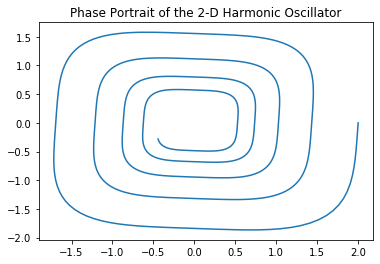

In [3]:
# Phase plane plot
plt.plot(cubic_data[0,:,0], cubic_data[0,:,1])
plt.title('Phase Portrait of the 2-D Harmonic Oscillator')

Now that we have simulated a dataset, let's create a suitable training data and augment it for learning.

# 2. LmmNet

Next, we train the LmmNet on the tensor data.

In [4]:
# we specify a LMM scheme and number of steps
dt = time_points[1] - time_points[0]
M = 1
scheme = 'AM'
model = lmmNet(dt, cubic_data, M, scheme, hidden_units=256)

N_Iter = 10000
model.train(N_Iter, debug=False)

In [5]:
import predict_lmmNet

x0 = cubic_data[0,0,:] # initial conditions
predicted_traj = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), x0, time_points)

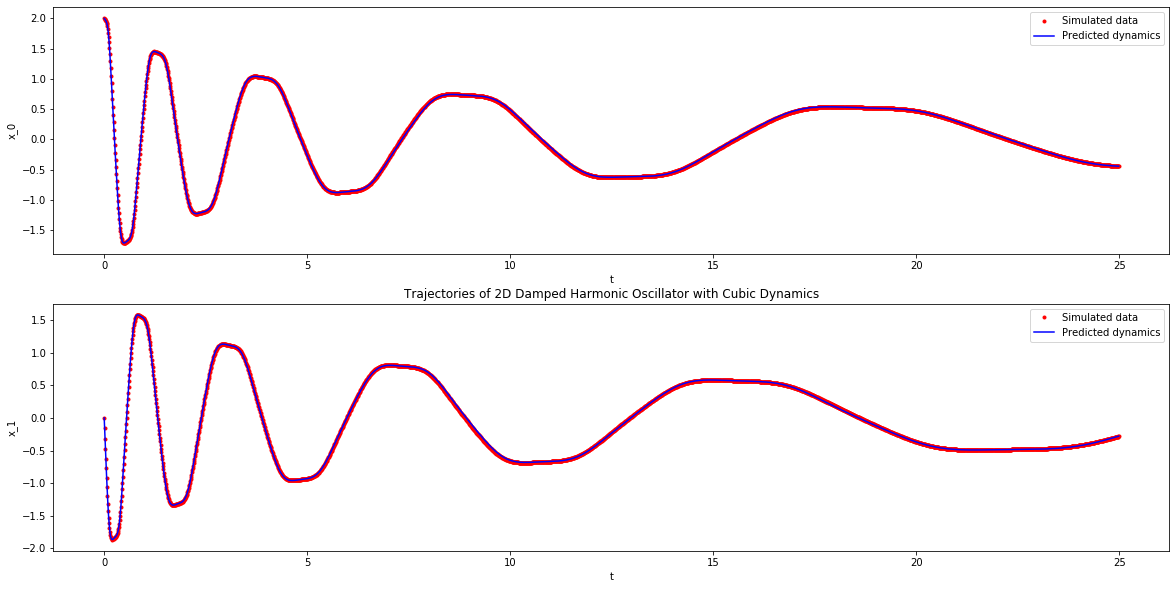

In [6]:
# plot the time-course of the predicted trajectory

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, cubic_data[0,:, species], 'r.', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'b-', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('x_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Damped Harmonic Oscillator with Cubic Dynamics')
plt.show()

Text(0.5, 1.0, 'Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

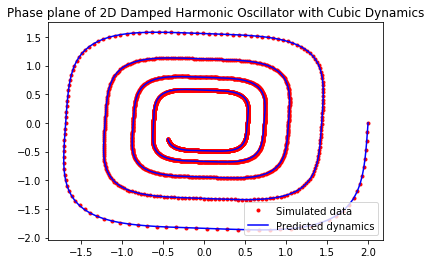

In [7]:
# Phase plane

plt.plot(cubic_data[0,:,0], cubic_data[0,:,1], 'r.', label='Simulated data')
plt.legend()
plt.plot(predicted_traj[:,0], predicted_traj[:,1], 'b-', label='Predicted dynamics')
plt.legend()
plt.title('Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

# 3. One-step machine learning method

Workflow:
* create and augment training data
* fit model with pairs of derivatives and time-series measurements as features
* make predictions and simulations by numerical integration of the learned model

In [8]:
# function to prepare data for training one-step method

def create_data(cubic_data, num=0):
    df = pd.DataFrame(cubic_data.numpy()[0])
    df.columns = ['x_component', 'y_component']
    df['Strain'] = [num] * df.shape[0]
    df = df.set_index('Strain')
    df['Time'] = time_points
    print('Original data shape:', df.shape)
    return df

# now generate and augment the training dataset
df = create_data(cubic_data)
feature_list = [] # here we do not have external time-series or control variables
target_list = ['x_component', 'y_component']

Original data shape: (2500, 3)


In [9]:
# create training data with different augmentation

df_train = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=2500)
df_train2 = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=5000)
df_train3 = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=30000)

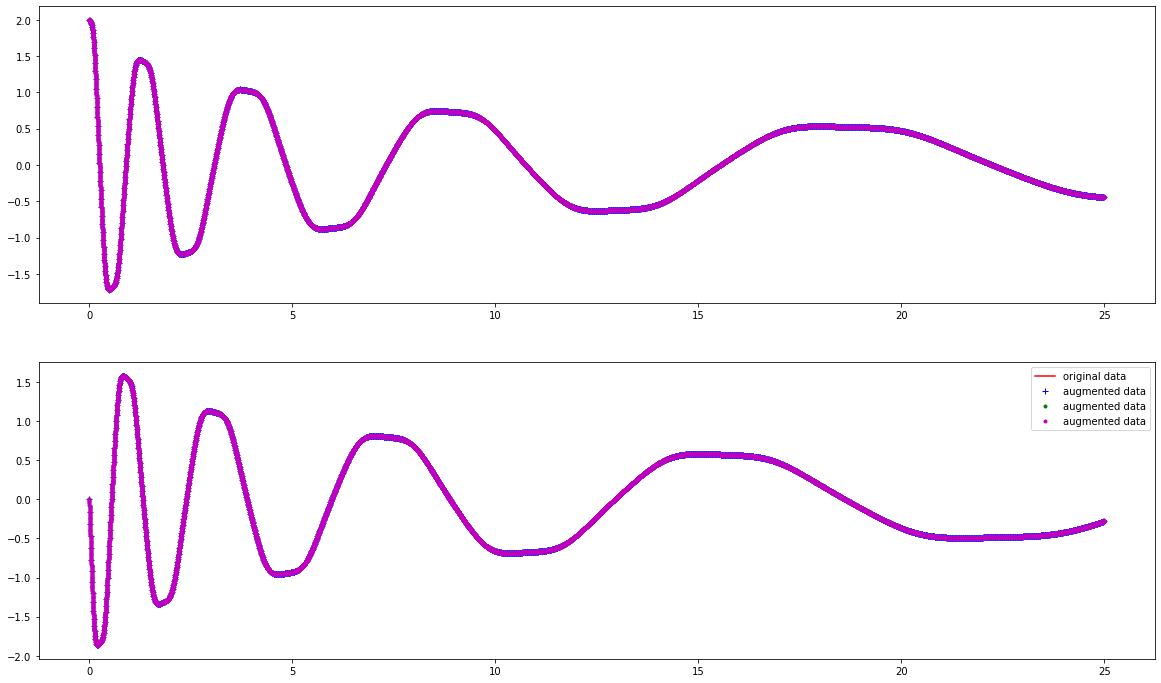

In [10]:
# make sure the augmented data corresponds to the original data

plt.figure(figsize = (20, 12))
for species in range(2):
    plt.subplot(2, 1, species + 1)
    plt.plot(time_points, df.iloc[:,species], 'r-', label='original data')
    plt.plot(time_points, df_train[('feature', df.columns[species])], 'b+', label='augmented data')
    plt.plot(df_train2.index.get_level_values(1), df_train2[('feature', df.columns[species])], 'g.', label='augmented data')
    plt.plot(df_train3.index.get_level_values(1), df_train3[('feature', df.columns[species])], 'm.', label='augmented data')
plt.legend()

x_component


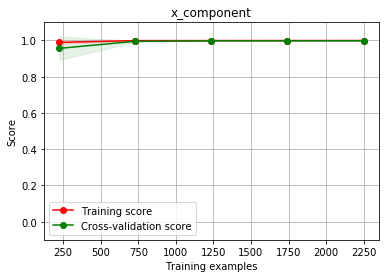

Target: x_component, CV Pearson R2 coefficient: 0.999745
y_component


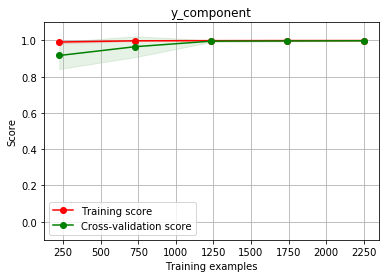

Target: y_component, CV Pearson R2 coefficient: 0.999772
Average training score: 0.9997583075957015
x_component RMSE: 0.00013829814950550547 standard deviation: 0.028443619487142784


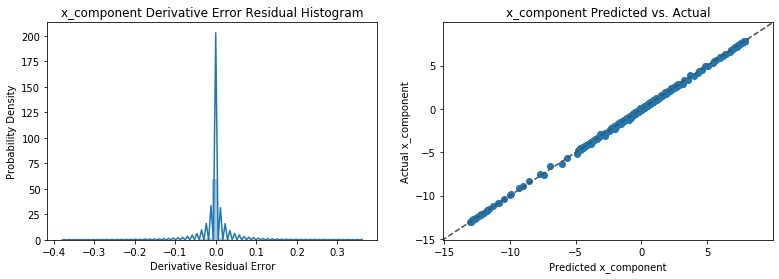

y_component RMSE: -0.000559225191628965 standard deviation: 0.027295086513623296


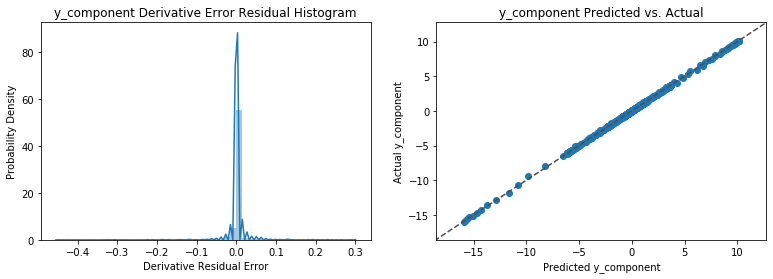

Total Derivative Mean Error: 0.04414905361851185 Error Standard Deviation: 0.07441433255958647


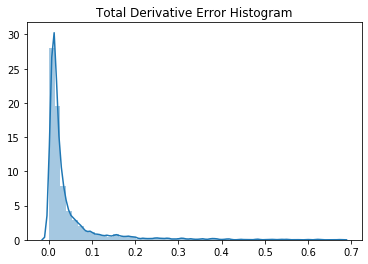

Real data:


,x_component,y_component
Strain,,
0,2.000000,0.000000
0,1.992028,-0.159044
0,1.983873,-0.316164
0,1.974847,-0.471225
0,1.963856,-0.623866
...,...,...
0,-0.441769,-0.288236
0,-0.442157,-0.286486
0,-0.442536,-0.284731


Predicted data:


,x_component,y_component
Time,,
0.00,2.000000,0.000000
0.01,1.994346,-0.158977
0.02,1.987980,-0.316799
0.03,1.980428,-0.472623
0.04,1.973619,-0.626396
...,...,...
24.95,0.423796,0.127098
24.96,0.423611,0.125376
24.97,0.423427,0.123655


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: x_component 5.073454721505575 RMSE percentage: 183.89610098163544
ML Fit: y_component 5.154407158916432 RMSE percentage: 167.8911955018268
ML model aggregate error
Average RMSE: 5.113930940211004
Total percentage error: 175.8936482417311


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


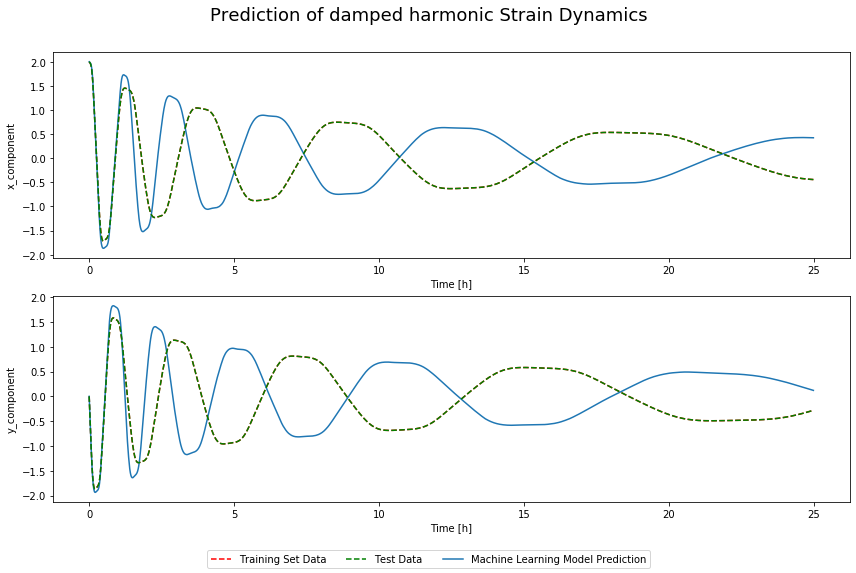

x_component


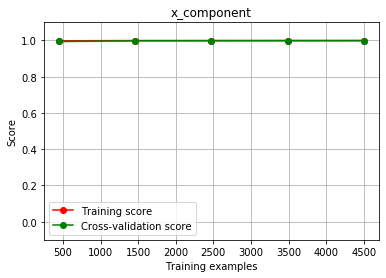

Target: x_component, CV Pearson R2 coefficient: 0.999853
y_component


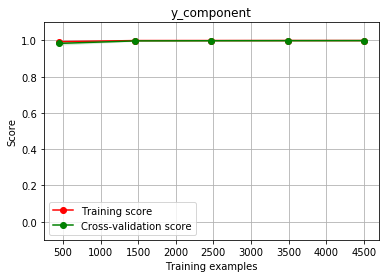

Target: y_component, CV Pearson R2 coefficient: 0.999894
Average training score: 0.9998737715228083
x_component RMSE: -0.00026614060809396553 standard deviation: 0.021565263902585702


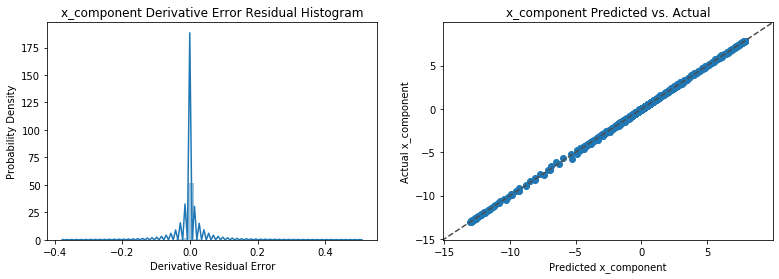

y_component RMSE: -0.00033359335546604844 standard deviation: 0.01851170562105328


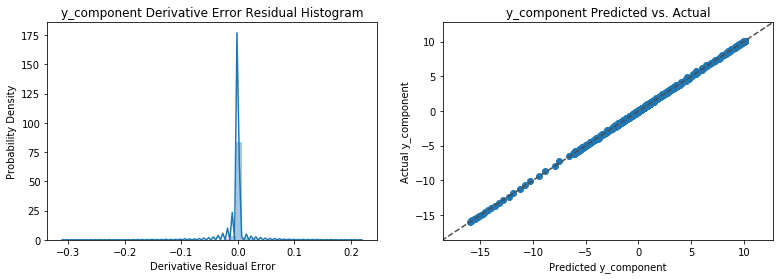

Total Derivative Mean Error: 0.032998849843809554 Error Standard Deviation: 0.06062633471228321


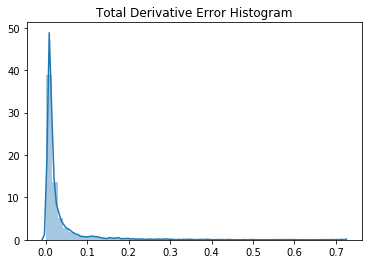

Real data:


,x_component,y_component
Strain,,
0,2.000000,0.000000
0,1.992028,-0.159044
0,1.983873,-0.316164
0,1.974847,-0.471225
0,1.963856,-0.623866
...,...,...
0,-0.441769,-0.288236
0,-0.442157,-0.286486
0,-0.442536,-0.284731


Predicted data:


,x_component,y_component
Time,,
0.00,2.000000,0.000000
0.01,1.992345,-0.158714
0.02,1.984392,-0.316052
0.03,1.976328,-0.471055
0.04,1.967147,-0.623803
...,...,...
24.95,0.419920,0.142680
24.96,0.419722,0.140985
24.97,0.419524,0.139293


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: x_component 4.895509120882687 RMSE percentage: 181.06593247869648


./source/predict_onestep.py:222: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: y_component 4.975304875277283 RMSE percentage: 181.29216575952657
ML model aggregate error
Average RMSE: 4.935406998079985
Total percentage error: 181.1790491191115


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


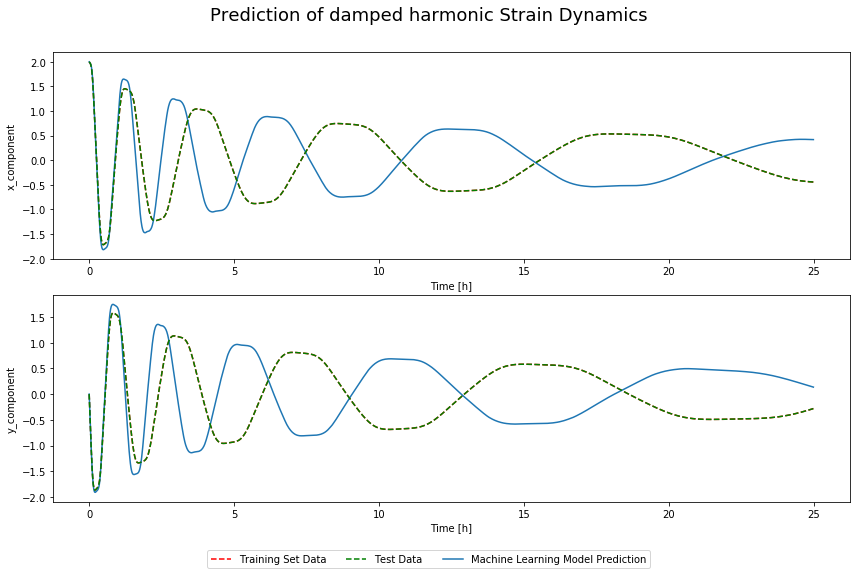

x_component


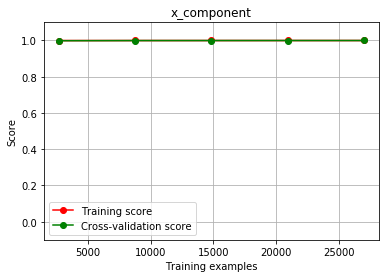

Target: x_component, CV Pearson R2 coefficient: 0.999990
y_component


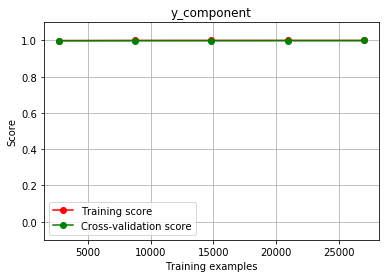

Target: y_component, CV Pearson R2 coefficient: 0.999992
Average training score: 0.9999912812574755
x_component RMSE: 4.793683934964001e-05 standard deviation: 0.005525389284269553


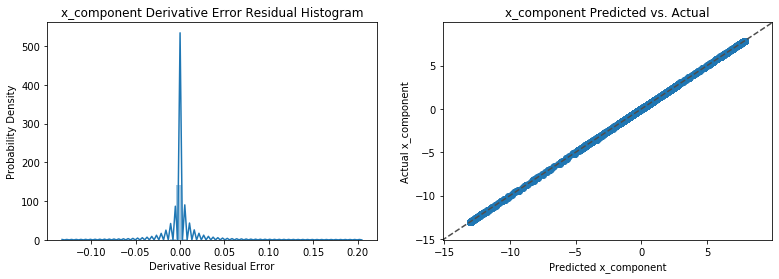

y_component RMSE: -6.131502724192145e-05 standard deviation: 0.0050149279872951525


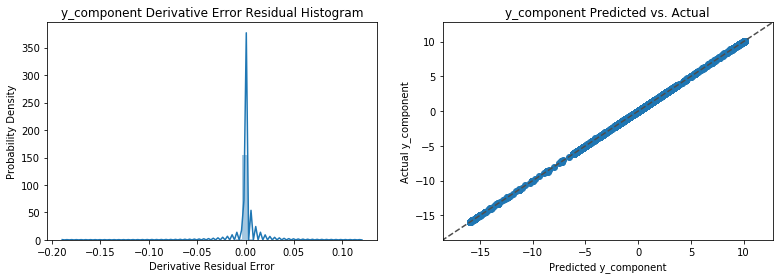

Total Derivative Mean Error: 0.014444194109845099 Error Standard Deviation: 0.02551645439519959


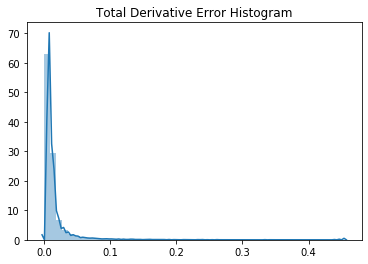

Real data:


,x_component,y_component
Strain,,
0,2.000000,0.000000
0,1.992028,-0.159044
0,1.983873,-0.316164
0,1.974847,-0.471225
0,1.963856,-0.623866
...,...,...
0,-0.441769,-0.288236
0,-0.442157,-0.286486
0,-0.442536,-0.284731


Predicted data:


,x_component,y_component
Time,,
0.00,2.000000,0.000000
0.01,1.992020,-0.159019
0.02,1.983842,-0.316161
0.03,1.974802,-0.471216
0.04,1.963776,-0.623893
...,...,...
24.95,-0.441380,-0.290090
24.96,-0.441778,-0.288344
24.97,-0.442166,-0.286594


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: x_component 0.018364560093826546 RMSE percentage: 25.284150965841185
ML Fit: y_component 0.018160830643420472 RMSE percentage: 19.397033691018954
ML model aggregate error
Average RMSE: 0.01826269536862351
Total percentage error: 22.34059232843007


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


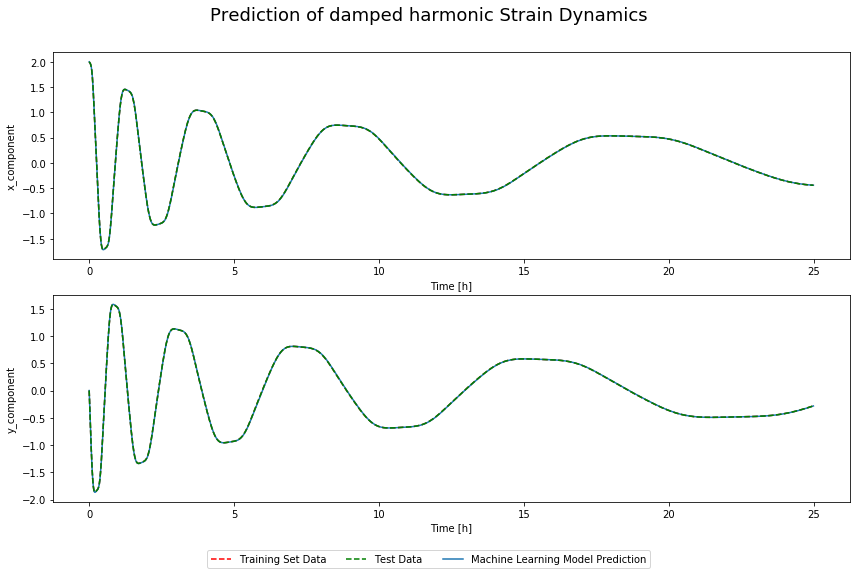

In [12]:
# train model and make predictions

def end_to_end_training(df, df_train, df_test):
    """
    df_train: training data augmented
    df_test: test data raw
    df: training data raw
    """
    rf_model = RandomForestRegressor(n_estimators=20)
    figure_path = './plots/'
    rf_dict, score_dict = train_onestep.train_classic(df_train, rf_model, plot=True,model_type='random_forest', figure_path=figure_path)
    train_onestep.compute_error(df_train,rf_dict,plot=True,model_type='random_forest')
    # now we make predictions via numerical integration
    # note that in predict_integrate, the function expects a normal dataframe and not the time-series multi-index dataframe
    time_points, predictions = predict_onestep.predict_integrate(df, df_test, rf_dict, target_list, feature_list, title='damped harmonic', plot=True,model_type='random_forest', subplots=(2,1), bio=False)
    return time_points, predictions

tp1, pred1 = end_to_end_training(df, df_train, df)
tp2, pred2 = end_to_end_training(df, df_train2, df)
tp3, pred3 = end_to_end_training(df, df_train3, df)

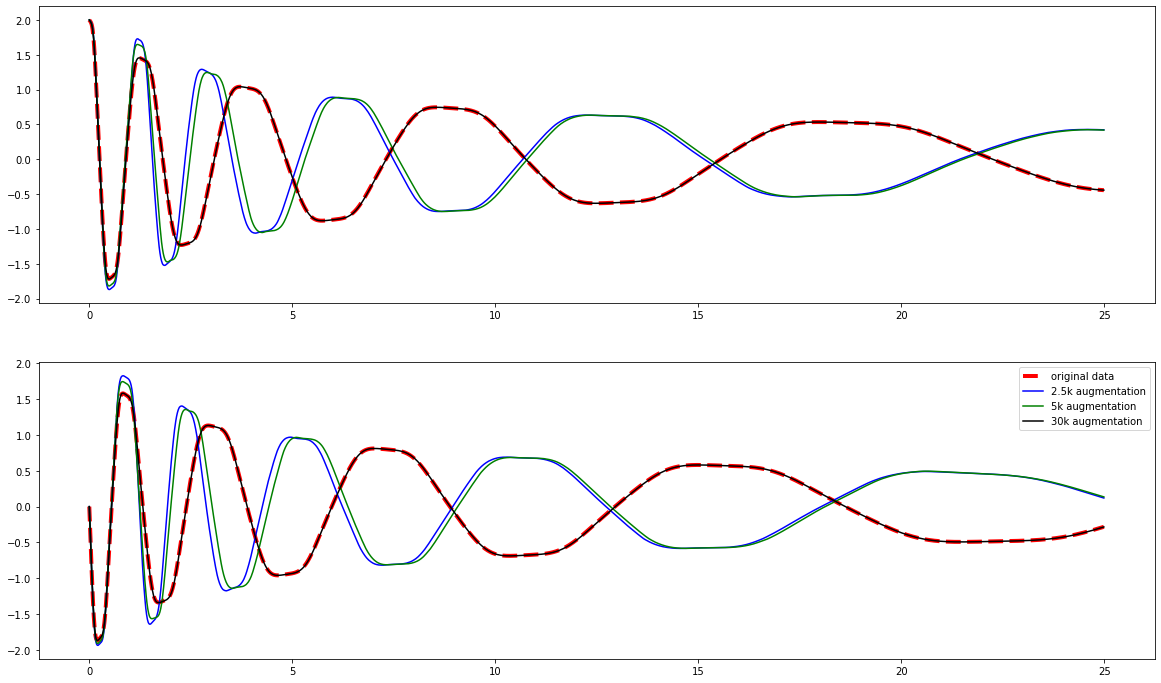

In [13]:
# plot the predictions in one figure

# make sure the augmented data corresponds to the original data
plt.figure(figsize = (20, 12))
for species in range(2):
    plt.subplot(2, 1, species + 1)
    plt.plot(time_points, df.iloc[:,species], 'r--', linewidth=4, label='original data')
    plt.plot(tp1, pred1.iloc[:,species], 'b-', label='2.5k augmentation')
    plt.plot(tp2, pred2.iloc[:,species], 'g-', label='5k augmentation')
    plt.plot(tp3, pred3.iloc[:,species], 'k-', label='30k augmentation')
    
plt.legend()

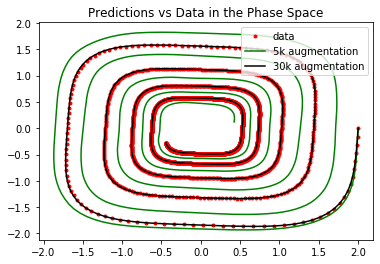

In [14]:
# Phase plane plot
plt.plot(cubic_data[0,:,0], cubic_data[0,:,1], 'r.', label='data')
plt.plot(pred1.iloc[:,0], pred1.iloc[:,1], 'g-', label='5k augmentation')
plt.plot(pred3.iloc[:,0], pred3.iloc[:,1], 'k-', label='30k augmentation')
plt.title('Predictions vs Data in the Phase Space')
plt.legend()

# 4. Prediction on unseen initial values

Let's evaluate the model on unseen initial conditions. First for one-step learning and next for LmmNet.

Original data shape: (2500, 3)
x_component


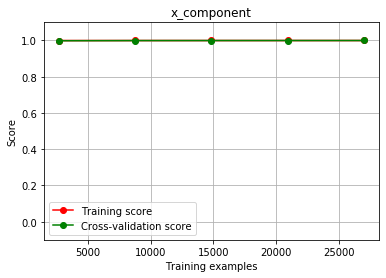

Target: x_component, CV Pearson R2 coefficient: 0.999987
y_component


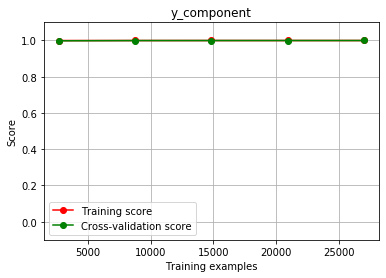

Target: y_component, CV Pearson R2 coefficient: 0.999991
Average training score: 0.999989149527958
x_component RMSE: 5.1987179883037253e-05 standard deviation: 0.006364755869284913


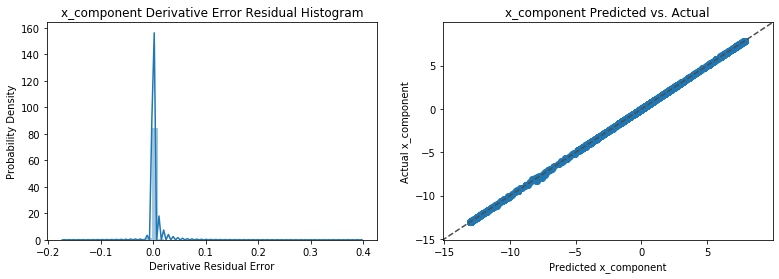

y_component RMSE: -9.658837276326142e-05 standard deviation: 0.005360570972343179


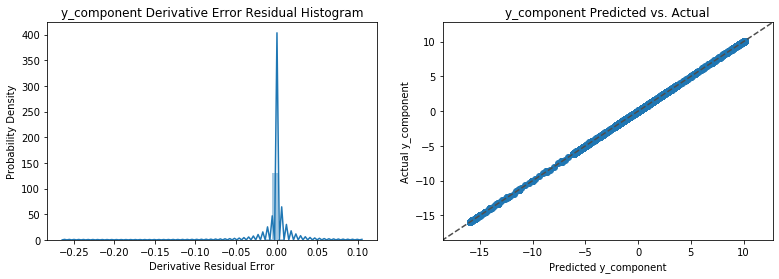

Total Derivative Mean Error: 0.014374558647420321 Error Standard Deviation: 0.02541420822219034


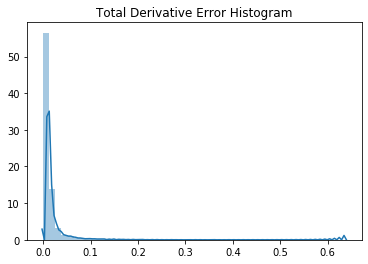

Real data:


,x_component,y_component
Strain,,
0,2.000000,0.000000
0,1.992028,-0.159044
0,1.983873,-0.316164
0,1.974847,-0.471225
0,1.963856,-0.623866
...,...,...
0,-0.441769,-0.288236
0,-0.442157,-0.286486
0,-0.442536,-0.284731


Predicted data:


,x_component,y_component
Time,,
0.00,2.000000,0.000000
0.01,1.992023,-0.158990
0.02,1.983811,-0.316056
0.03,1.974724,-0.471041
0.04,1.963712,-0.623640
...,...,...
24.95,-0.441819,-0.294173
24.96,-0.442220,-0.292429
24.97,-0.442613,-0.290682


./source/predict_onestep.py:217: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  

ML Fit: x_component 0.02545097075200058 RMSE percentage: 15.274922432669937


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])


ML Fit: y_component 0.0249290490162664 RMSE percentage: 21.780428726763272
ML model aggregate error
Average RMSE: 0.025190009884133488
Total percentage error: 18.527675579716608


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


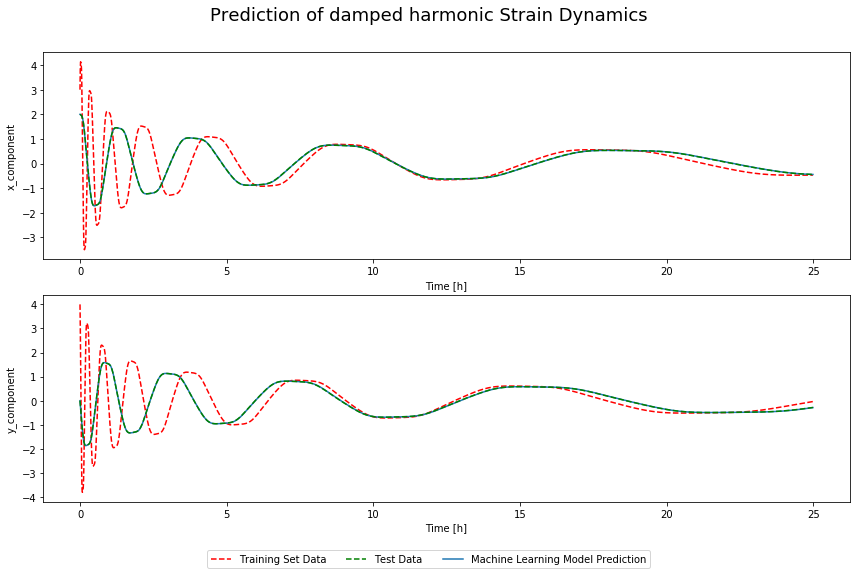

In [15]:
time_points, data2 = harmonic.simulate_custom(xinit=3, yinit=4)
df2 = create_data(data2, num=1)
tp, pred = end_to_end_training(df, df_train3, df2)

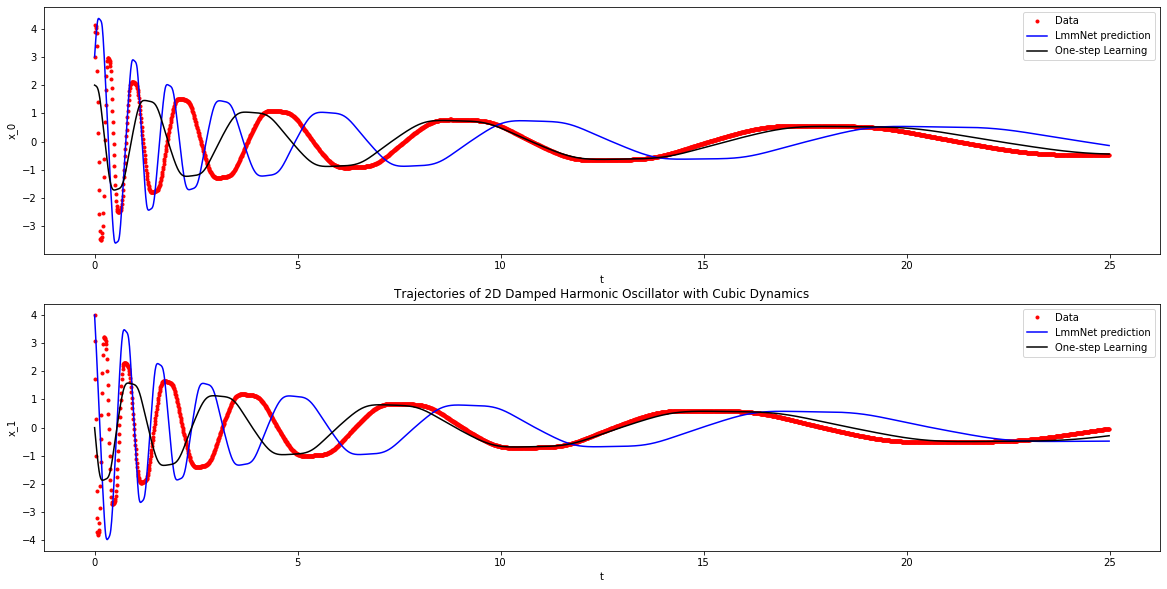

In [18]:
pred_lnet = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), data2[0,0,:], time_points)

# plot the time-course of the predicted trajectory
plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, data2[0,:, species], 'r.', label='Data')
    plt.plot(time_points, pred_lnet[:,species], 'b-', label='LmmNet prediction')
    plt.plot(tp, pred.iloc[:,species], 'k-', label='One-step Learning')
    plt.xlabel('t')
    plt.ylabel('x_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Damped Harmonic Oscillator with Cubic Dynamics')
plt.show()

Text(0.5, 1.0, 'Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

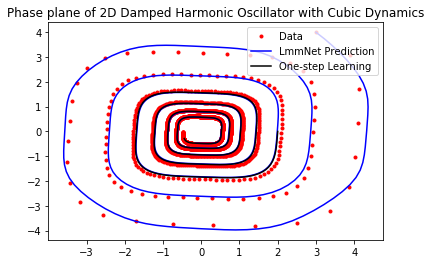

In [17]:
# Phase plane

plt.plot(data2[0,:,0], data2[0,:,1], 'r.', label='Data')
plt.plot(pred_lnet[:,0], pred_lnet[:,1], 'b-', label='LmmNet Prediction')
plt.plot(pred.iloc[:,0], pred.iloc[:,1], 'k-', label='One-step Learning')
plt.legend()
plt.title('Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

Note that in the SINDy paper, the evaluation is only done on the training data as below.

<img src=image/cubic-sindy.png alt="drawing" align ="left" width="300"/>  

**SINDy results (Brunton et al., 2016)**. 